In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub
import os                                                ##  Modul os je součástí standardní knihovny Pythonu a umožňuje pracovat se soubory a adresáři v operačním systému. 
                                                         ##  Často se používá ke čtení/zápisu souborů, získání cest k souborům a manipulaci s adresáři. 

from PIL import Image                                    ## PIL (Python Imaging Library, dnes známá jako Pillow) je knihovna pro manipulaci s obrázky. 
                                                         ## Image umožňuje otevírat, upravovat a ukládat obrázky ve formátech jako PNG, JPEG, BMP atd. 

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split     ## Rozdělení datasetu na trénovací a testovací část
from keras.utils import to_categorical                   ##  Konverze štítků do One-Hot Encoding, Místo číselného označení jako 0, 1, 2, 
                                                         ##  což by mohlo způsobit chyby v učení (síť by mohla mylně považovat 2 za „větší“ než 1), použijeme One-Hot Encoding:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionV3
from keras.applications import MobileNetV3Large     ## je předtrénovaný model hlubokého učení určený pro rozpoznávání obrazu.
                                                    ## Model je předtrénován na obrovském datasetu ImageNet a lze jej dále upravit (tzv. transfer learning).
from keras.layers import GlobalAveragePooling2D     ## redukuje dimenzionalitu výstupních dat.
from keras.models import Model                      ## Model umožňuje sestavit vlastní architekturu neuronové sítě v Kerasu.
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.regularizers import l2
from keras.utils import to_categorical

In [4]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

## Načtení a preprocessing dat

In [5]:
path = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE"

In [6]:
fotky_emoce = os.listdir(f"{path}/train_OK")

In [7]:
# Načtení fotek a přiřazení názvů emocí ( labling)
X = []     
y = []     
encoding = {}   

for index, emoce in enumerate(fotky_emoce):        
  encoding[index] = emoce
  folder_path = os.path.join(f"{path}/train_OK", emoce)

  # Vytvoření datasetu
  image_list = []     
  for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):    
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img_resized = img.resize((48, 48))   # změna velikosto obrázku   
        img_array = np.array(img_resized)    # převod na numpy array
        image_list.append(img_array)         # rozšíření seznamu obrázků

  X += image_list    #   Přidáme všechny obrázky z této složky do seznamu X.
  y += [index] * len(image_list)  ## přiřazení čísel k labelům 

In [8]:
X = np.stack(X)
y = np.array(y)
## X = X / 255  # Normalizování obrázků

In [9]:
# rozdělení, trénink test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# one hot encoding y 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
# Zastavení trénování modelu, pokud nejsou změny větší než 0,3%
early = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.003,
    patience=10,
    restore_best_weights=True,
)
# Uložení nejlepšího modelu
save = ModelCheckpoint(
    filepath="best_model_mobilnet.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch"
)

## Trénování modelu na základě MobilNET

In [11]:
# Convert single-channel grayscale to 3-channel format (R=G=B=gray)
X = np.stack((X,) * 3, axis=-1)

In [12]:
X.shape

(13441, 48, 48, 3)

In [13]:
# vytvořit trénovací sadu z nenaškálovaných dat
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, stratify=y, random_state=42)       ##  20 % dat se použije pro testování, 80 % pro trénování,  42 - zajišťuje, že náhodné rozdělení bude stejné při každém spuštění.
                                                                       ## stratify=y – zajistí, že rozložení tříd (emocí) bude stejné v trénovacím i testovacím datasetu.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
# Načtení základního modelu MobileNetV3Large bez vrchní plně propojené vrstvy
base_model = MobileNetV3Large(
    input_shape=(48, 48, 3),  # Vstupní tvar pro šedotónové obrázky
    include_top=False,
)

# Zamrznutí základního modelu, aby se jeho váhy během trénování neměnily
base_model.trainable = False

# Vytvoření vlastních vrstev pro specifickou úlohu
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
     ## model.add(Dropout(0.3))
    layers.Dense(len(fotky_emoce), activation='softmax')  # 'num_classes' je počet tříd ve vašem datasetu
])

# Kompilace modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\zitao\anaconda3\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 2, 2, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,120,263 (11.90 MB)

 Trainable params: 123,911 (484.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [16]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 55s 114ms/step - accuracy: 0.3880 - loss: 1.6863 - val_accuracy: 0.5389 - val_loss: 1.3073
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.4866 - loss: 1.3973 - val_accuracy: 0.5247 - val_loss: 1.2815
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - accuracy: 0.5196 - loss: 1.3148 - val_accuracy: 0.5571 - val_loss: 1.2379
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.5162 - loss: 1.3044 - val_accuracy: 0.5597 - val_loss: 1.2284
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.5304 - loss: 1.2805 - val_accuracy: 0.5627 - val_loss: 1.2229
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step - accuracy: 0.5310 - loss: 1.2687 - val_accuracy: 0.5787 - val_loss: 1.2059
Epoch 7/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.5473 - loss: 1.2295 - val_accuracy: 0.5723 - val_loss: 1.1841
Epoch 8/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.5553 - loss: 

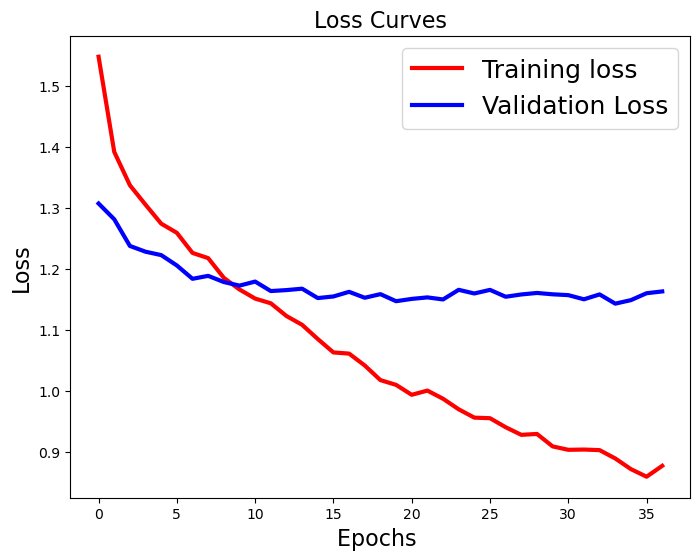

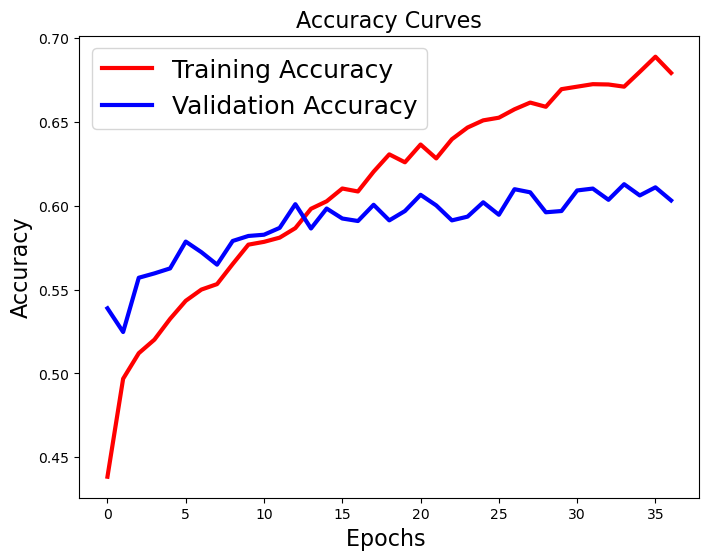

In [17]:
plot_history(history)

In [18]:
model = load_model("best_model_mobilnet.keras")

In [19]:
y_pred = model.predict(X_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step


In [20]:
y_pred = np.argmax(y_pred, axis=1)

In [21]:
y_test = np.argmax(y_test, axis=1)

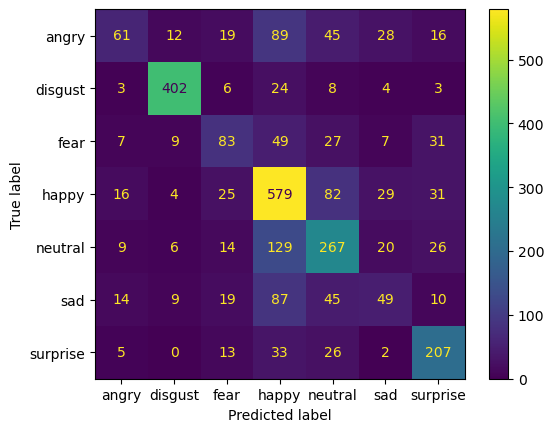

In [22]:
## plt.title("Confusion Matrix  - Vlastní neuronka")  # Název grafu


class_labels = list(encoding.values())
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()